## 7.2 Autoencoder

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn import datasets

class Autoencoder:
    def __init__(self, input_dim, hidden_dim, epoch=250, learning_rate=0.001):
        self.epoch = epoch
        self.learning_rate = learning_rate
        
        x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim])
        
        with tf.name_scope('encode'):
            weights = tf.Variable(tf.random_normal([input_dim, hidden_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([hidden_dim]), name='biases')
            encoded = tf.nn.tanh(tf.matmul(x, weights) + biases)
        with tf.name_scope('decode'):
            weights = tf.Variable(tf.random_normal([hidden_dim, input_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([input_dim]), name='biases')
            decoded = tf.matmul(encoded, weights) + biases
            
        self.x = x
        self.encoded = encoded
        self.decoded = decoded
        self.loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(self.x, self.decoded))))
        
        self.train_op = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)
        self.saver = tf.train.Saver()
        
    def train(self, data):
        num_samples = len(data)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.epoch):
                for j in range(num_samples):
                    l, _ = sess.run([self.loss, self.train_op], feed_dict={self.x:[data[j]]})
                if i % 10 == 0:
                    print('epoch {0}: loss = {1}'.format(i, l))
                    self.saver.save(sess, './model.ckpt')
            self.saver.save(sess, './model.ckpt')
    def test(self, data):
        with tf.Session() as sess:
            self.saver.restore(sess, "./model.ckpt")
            hidden, reconstructed = sess.run([self.encoded, self.decoded], feed_dict={self.x:data})
            print('input',data)
            print('compressed', hidden)
            print('reconstructed', reconstructed)
            return reconstructed
        
hidden_dim = 1
data = datasets.load_iris().data
input_dim = len(data[0])
ae = Autoencoder(input_dim, hidden_dim)
ae.train(data)
ae.test([[8, 4, 6, 2]])

## 7.3 Batch training

* 시간에 대한 압력이 없다면, 네트워크를 하나씩 훈련하는 것이 가장 안전한 방법이다.
* 하지만 네트워크가 원하는 시간보다 오래 걸린다면, 입력으로 한번에 여러 데이터를 넣고 훈련하는 것이 좋은 해결책이며 이를 batch training이라고 부른다.
* 일반적으로 batch size가 증가되면 알고리즘의 속도는 빨라지지만, 성공적인 수렴은 거의 보장되지 않는다.
* 양날의 칼과도 같기 때문에 적절한 사용이 필요하다.


In [14]:
import numpy as np
import tensorflow as tf
from sklearn import datasets

class Autoencoder:
    def __init__(self, input_dim, hidden_dim, epoch=250, batch_size=10, learning_rate=0.001):
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim])
        
        with tf.name_scope('encode'):
            weights = tf.Variable(tf.random_normal([input_dim, hidden_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([hidden_dim]), name='biases')
            encoded = tf.nn.tanh(tf.matmul(x, weights) + biases)
        with tf.name_scope('decode'):
            weights = tf.Variable(tf.random_normal([hidden_dim, input_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([input_dim]), name='biases')
            decoded = tf.matmul(encoded, weights) + biases
            
        self.x = x
        self.encoded = encoded
        self.decoded = decoded
        self.loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(self.x, self.decoded))))
        
        self.train_op = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)
        self.saver = tf.train.Saver()

    def get_batch(self,X, size):
        a = np.random.choice(len(X), size, replace=False)
        return X[a]

    def train(self, data):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.epoch):
                for j in range(np.shape(data)[0] // self.batch_size):
                    batch_data = self.get_batch(data, self.batch_size)
                    l, _ = sess.run([self.loss, self.train_op], feed_dict={self.x:batch_data})
                if i % 10 == 0:
                    print('epoch {0}: loss = {1}'.format(i, l))
                    self.saver.save(sess, './model.ckpt')
            self.saver.save(sess, './model.ckpt')
    def test(self, data):
        with tf.Session() as sess:
            self.saver.restore(sess, "./model.ckpt")
            hidden, reconstructed = sess.run([self.encoded, self.decoded], feed_dict={self.x:data})
            print('input',data)
            print('compressed', hidden)
            print('reconstructed', reconstructed)
            return reconstructed

In [ ]:
hidden_dim = 1
data = datasets.load_iris().data
input_dim = len(data[0])
print(np.shape(data))
print(np.shape(data)[0] // 10)
ae = Autoencoder(input_dim, hidden_dim)
ae.train(data)
ae.test([[8, 4, 6, 2]])

In [24]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo)
    fo.close()
    return dict

def grayscale(a):
    return a.reshape(a.shape[0], 3, 32, 32).mean(1).reshape(a.shape[0], -1)

def data_show(data, data_len):
    plt.rcParams['figure.figsize'] = (2, 2)
    for i in range(data_len):
        img = np.reshape(data[i,:], (32, 32))
        plt.subplot(1, data_len, i+1)
        plt.imshow(img, cmap='gray')
        
names = unpickle('./cifar-10-batches-py/batches.meta')['label_names']

data, labels = [], []
for i in range(1, 6):
    filename = './cifar-10-batches-py/data_batch_' + str(i)
    batch_data = unpickle(filename)
    if len(data) > 0:
        data = np.vstack((data, batch_data['data']))
        labels = np.hstack((labels, batch_data['labels']))
    else:
        data = batch_data['data']
        labels = batch_data['labels']

In [25]:
data = grayscale(data)

x = np.matrix(data)
y = np.array(labels)

horse_indices = np.where(y == 7)[0]
horse_x = x[horse_indices]

input_dim = np.shape(horse_x)[1]
hidden_dim = 100
ae = Autoencoder(input_dim, hidden_dim, 1000)
ae.train(horse_x)

epoch 0: loss = 103.323234558
epoch 10: loss = 55.1757621765
epoch 20: loss = 52.0701446533
epoch 30: loss = 47.649017334
epoch 40: loss = 51.8785972595
epoch 50: loss = 45.6655502319
epoch 60: loss = 49.934425354
epoch 70: loss = 44.3475494385
epoch 80: loss = 44.2085418701
epoch 90: loss = 45.0628814697
epoch 100: loss = 48.9632987976
epoch 110: loss = 52.0625457764
epoch 120: loss = 58.7059288025
epoch 130: loss = 41.6833114624
epoch 140: loss = 46.6377182007
epoch 150: loss = 49.4438781738
epoch 160: loss = 51.671875
epoch 170: loss = 47.7374763489
epoch 180: loss = 45.4989852905
epoch 190: loss = 53.5972251892
epoch 200: loss = 49.1871070862
epoch 210: loss = 54.024646759
epoch 220: loss = 51.8799819946
epoch 230: loss = 46.0912590027
epoch 240: loss = 42.0753364563
epoch 250: loss = 46.9543113708
epoch 260: loss = 49.1059188843
epoch 270: loss = 43.8588409424
epoch 280: loss = 42.5759353638
epoch 290: loss = 49.4515571594
epoch 300: loss = 51.7918319702
epoch 310: loss = 47.36800

(1, 1024)


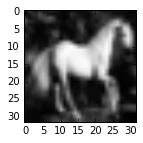

In [26]:
test_data = unpickle('./cifar-10-batches-py/test_batch')
test_x = grayscale(test_data['data'])
test_labels = np.array(test_data['labels'])
test_1 = test_x[13].reshape(1, np.shape(test_x[13])[0])
print(np.shape(test_1))
data_show(test_1, 1)

('input', array([[ 34.        ,  60.66666667,  36.33333333, ...,   5.        ,
          3.66666667,   5.        ]]))
('compressed', array([[ 1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
         1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
        -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1., -1., -1., -1.,  1.,
         1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,
         1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
         1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
        -1., -1.,  1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,
         1., -1., -1., -1.,  1.,  1., -1.,  1., -1.]], dtype=float32))
('reconstructed', array([[-12.63776112,  -8.10105038,  -6.64948606, ...,   0.62115502,
          2.36373949,  10.83516312]], dtype=float32))
(1, 1024)


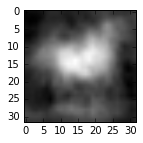

In [27]:
reconst = ae.test(test_1)
print(np.shape(reconst))
data_show(reconst, 1)